# General DA fittings and Fokker-Planck comparisons (Hénon map)

## Setup scripts if we are under SWAN

In [ ]:
# Working in the right path
%cd /eos/project/d/da-and-diffusion-studies/DA_Studies/Simulations/Models/da_sixtrack

In [ ]:
# Install the libraries
import sys
!{sys.executable} -m pip install --user tqdm pynverse sixtrackwrap crank-nicolson-numba henon-map symplectic-map
!{sys.executable} -m pip install --user --upgrade sixtrackwrap 
!{sys.executable} -m pip install --user --upgrade crank-nicolson-numba 
!{sys.executable} -m pip install --user --upgrade henon-map 
!{sys.executable} -m pip install --user --upgrade symplectic-map
!export PYTHONPATH=$CERNBOX_HOME.local/lib/python3.7/site-packages:$PYTHONPATH

In [ ]:
# For this "presentation" only!
import warnings
warnings.filterwarnings('ignore')

## Imports

In [ ]:
%matplotlib widget

In [ ]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

# Personal libraries
import sixtrackwrap as sx
import crank_nicolson_numba.nekhoroshev as nk

from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

import pandas as pd

from scipy.special import lambertw
from scipy.interpolate import interp1d

import warnings
import os

## Prepare inverse functions for obtaining DA from loss values

In [2]:
from pynverse import inversefunc

# Uniform 4D distribution

@njit
def uniform_loss(DA, DA0):
    return (DA ** 4 / DA0 ** 4)

@njit
def DA_from_unifom_loss(loss, DA0):
    return np.power((loss * DA0 ** 4), 1/4)

# Symmetric 4D gaussian

@njit
def symmetric_gaussian_loss(DA, sigma, DA0):
    baseline = - np.exp(- 0.5 * (DA0 / sigma) ** 2) * (DA0 ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2
    return (- np.exp(- 0.5 * (DA / sigma) ** 2) * (DA ** 2 + 2 * sigma ** 2) + 2 * sigma ** 2) / baseline


def DA_from_symmetric_gaussian_loss(loss, sigma, DA0):
    func = inversefunc(
        lambda x: symmetric_gaussian_loss(x, sigma, DA0),
        domain=[0.0, DA0]
    )
    return func(loss)
    

## Define Fitting Models!

### $\chi^2$ function

In [3]:
def chi_2(original, estimate):
    return np.sum(np.power(estimate - original, 2) / original)

### Model 2

$$D(N) = \rho_\ast \left(\frac{\kappa}{2e}\right)^\kappa \frac{1}{\ln^\kappa\frac{N}{N_0}}$$


In [4]:
@njit
def model_2(x, rho, n0, k):
    return rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))


def explore_k_model_2(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a, b : model_2(x, a, b, k),
            turns,
            da,
            bounds=([0, 0.00001],[np.inf, turns[-1]-0.0001])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(da, model_2(turn_sampling, par[0], par[1], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

### Model 4

$$D(N)=\rho_{*} \times \frac{1}{\left[-2 \mathrm{e} \lambda \mathcal{W}_{-1}\left(-\frac{1}{2 \mathrm{e} \lambda}\left(\frac{\rho_{\ast}}{6}\right)^{1 / \kappa}\left(\frac{8}{7} N\right)^{-1 /(\lambda \kappa)}\right)\right]^{\kappa}}
$$

(with $\lambda=0.5$)

In [5]:
def model_4(x, rho, k):
    lamb = 0.5
    return np.real(
        rho
        / np.power(-2 * np.exp(1) * lamb * lambertw(- (1 / (2 * np.exp(1) * lamb)) * np.power(rho / 6, 1 / k) * np.power((8/7) * x, -1 / (lamb * k)), -1), k)
    )

def explore_k_model_4(turns, da, k_min, k_max, n_samples):
    ks = np.linspace(k_min, k_max, n_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a : model_4(x, a, k),
            turns,
            da,
            bounds=([0.1],[np.inf])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(da, model_4(turn_sampling, par[0], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

### A more free Model 4

$$D(N)=\rho_{*} \times \frac{1}{\left[-2 \mathrm{e} \lambda \mathcal{W}_{-1}\left(-\frac{1}{\lambda\kappa}\left(\frac{N}{N_0}\right)^{-\frac{1}{\lambda\kappa}}\right)\right]^{\kappa}}
$$

(with $\lambda=0.5$)

In [6]:
def model_4_free(x, rho, n0, k):
    lamb = 0.5
    temp = (
        rho / (np.power(- 2 * lamb * np.exp(1) * lambertw(- (1 / (lamb * k)) * np.power(x / n0, - 1 / (lamb * k)), -1), k))
    )
    
    return np.real(temp) # TODO: FIX IT WITH PROPER MATH!!!


def explore_model_4_free(turns, da, k_min, k_max, k_samples):
    ks = np.linspace(k_min, k_max, k_samples)
    pars = []
    errs = []
    co_pars = []
    for k in tqdm(ks):
        par, co_par = curve_fit(
            lambda x, a, b : model_4_free(x, a, b, k),
            turns,
            da,
            bounds=([0.01, 0.01], [np.inf, turns[-1] - 0.1])
        )
        pars.append(par)
        co_pars.append(co_par)
        errs.append(chi_2(da, model_4_free(turn_sampling, par[0], par[1], k)))
    return np.asarray(pars), np.asarray(errs), np.asarray(co_pars)

## Load data and setup original DA

In [7]:
savepath = "data/"

sigma = 0.2
turn_samples = 100
skipper = 1

cut_point = 1.0

In [8]:
epsilons = []

real_losses = []
uniform_losses = []
gaussian_losses = []

real_DAs = []
uniform_DAs = []
gaussian_DAs = []

files = list(sorted(list(filter(lambda f: "henon_eps_" in f, os.listdir(savepath))), key=lambda f: float(f[10: -4])))[::skipper]

for f in tqdm(files):
    print("Loading file: ", f)
    epsilon = float(f[10: -4])
    epsilons.append(epsilon)
    engine = sx.uniform_radial_scanner.load_values(savepath + f)

    baseline_samples = engine.baseline_samples
    min_turns = 10**3
    max_turns = 10**6
    d_r = engine.dr
    turn_sampling = np.linspace(min_turns, max_turns, turn_samples, dtype=np.int)[::-1]
    
    print("Real part")
    real_DAs.append(engine.compute_DA_standard(turn_sampling))
    print("Done DA")
    
    print("Uniform part")
    engine.assign_weights(sx.assign_uniform_distribution())
    uniform_losses.append(engine.compute_loss(turn_sampling, cut_point))
    uniform_DAs.append(DA_from_unifom_loss(uniform_losses[-1], cut_point))
    
    print("Gaussian part")
    engine.assign_weights(sx.assign_symmetric_gaussian(sigma))
    gaussian_losses.append(engine.compute_loss(turn_sampling, cut_point))
    gaussian_DAs.append(DA_from_symmetric_gaussian_loss(gaussian_losses[-1], sigma, cut_point))
    


Loading file:  henon_eps_2.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_4.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_6.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_8.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_10.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_12.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_14.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_16.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_18.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_20.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_22.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_24.pkl
Real part
Done DA
Uniform part
Gaussian part
Loading file:  henon_eps_26.pkl
Real part
Done DA
Uniform part
Gaussian part
Loa

## General fitting of all the Hénon maps across all models

In [9]:
labels = (
    ("epsilon", ""),
    ("type", ""),
    ("sigma", ""),
    ("Model 2", "k"),
    ("Model 2", "k err"),
    ("Model 2", "rho"),
    ("Model 2", "rho err"),
    ("Model 2", "N0"),
    ("Model 2", "N0 err"),
    ("Model 2", "Chi2"),
    ("Model 4 (2 free pars)", "k"),
    ("Model 4 (2 free pars)", "k err"),
    ("Model 4 (2 free pars)", "rho"),
    ("Model 4 (2 free pars)", "rho err"),
    ("Model 4 (2 free pars)", "lambda"),
    ("Model 4 (2 free pars)", "Chi2"),
    ("Model 4 (3 free pars)", "k"),
    ("Model 4 (3 free pars)", "k err"),
    ("Model 4 (3 free pars)", "rho"),
    ("Model 4 (3 free pars)", "rho err"),
    ("Model 4 (3 free pars)", "N0"),
    ("Model 4 (3 free pars)", "N0 err"),
    ("Model 4 (3 free pars)", "lambda"),
    ("Model 4 (3 free pars)", "Chi2"),
)

fitting_data = pd.DataFrame(columns=pd.MultiIndex.from_tuples(labels))
lost_table = []

In [10]:
k_min = 0.1
k_max = 2.00
samples = 100

ks = np.linspace(k_min, k_max, samples)

In [11]:
for i, eps in tqdm(list(enumerate(epsilons))):
    # Model 2
    real_pars, real_errs, real_co_pars = explore_k_model_2(
        turn_sampling, real_DAs[i], k_min, k_max, samples
    )
    uniform_loss_pars, uniform_loss_errs, uniform_loss_co_pars = explore_k_model_2(
        turn_sampling, uniform_DAs[i], k_min, k_max, samples
    )
    gaussian_loss_pars, gaussian_loss_errs, gaussian_loss_co_pars = explore_k_model_2(
        turn_sampling, gaussian_DAs[i], k_min, k_max, samples
    )

    real_selected_err_2 = np.min(real_errs)
    real_selected_k_2 = ks[np.argmin(real_errs)]
    real_selected_pars_2 = real_pars[np.argmin(real_errs)]
    real_selected_co_pars_2 = real_co_pars[np.argmin(real_errs)]

    uniform_loss_selected_err_2 = np.min(uniform_loss_errs)
    uniform_loss_selected_k_2 = ks[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_pars_2 = uniform_loss_pars[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_co_pars_2 = uniform_loss_co_pars[np.argmin(uniform_loss_errs)]
    
    gaussian_loss_selected_err_2 = np.min(gaussian_loss_errs)
    gaussian_loss_selected_k_2 = ks[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_pars_2 = gaussian_loss_pars[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_co_pars_2 = gaussian_loss_co_pars[np.argmin(gaussian_loss_errs)]
    
    # Model 4 (2 pars)
    real_pars, real_errs, real_co_pars = explore_k_model_4(
        turn_sampling, real_DAs[i], k_min, k_max, samples
    )
    uniform_loss_pars, uniform_loss_errs, uniform_loss_co_pars = explore_k_model_4(
        turn_sampling, uniform_DAs[i], k_min, k_max, samples
    )
    gaussian_loss_pars, gaussian_loss_errs, gaussian_loss_co_pars = explore_k_model_4(
        turn_sampling, gaussian_DAs[i], k_min, k_max, samples
    )

    real_selected_err_4 = np.min(real_errs)
    real_selected_k_4 = ks[np.argmin(real_errs)]
    real_selected_pars_4 = real_pars[np.argmin(real_errs)]
    real_selected_co_pars_4 = real_co_pars[np.argmin(real_errs)]

    uniform_loss_selected_err_4 = np.min(uniform_loss_errs)
    uniform_loss_selected_k_4 = ks[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_pars_4 = uniform_loss_pars[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_co_pars_4 = uniform_loss_co_pars[np.argmin(uniform_loss_errs)]
    
    gaussian_loss_selected_err_4 = np.min(gaussian_loss_errs)
    gaussian_loss_selected_k_4 = ks[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_pars_4 = gaussian_loss_pars[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_co_pars_4 = gaussian_loss_co_pars[np.argmin(gaussian_loss_errs)]
    
    # Model 4 (3 pars)
    real_pars, real_errs, real_co_pars = explore_model_4_free(
        turn_sampling, real_DAs[i], k_min, k_max, samples
    )
    uniform_loss_pars, uniform_loss_errs, uniform_loss_co_pars = explore_model_4_free(
        turn_sampling, uniform_DAs[i], k_min, k_max, samples
    )
    gaussian_loss_pars, gaussian_loss_errs, gaussian_loss_co_pars = explore_model_4_free(
        turn_sampling, gaussian_DAs[i], k_min, k_max, samples
    )

    real_selected_err_4_free = np.min(real_errs)
    real_selected_k_4_free = ks[np.argmin(real_errs)]
    real_selected_pars_4_free = real_pars[np.argmin(real_errs)]
    real_selected_co_pars_4_free = real_co_pars[np.argmin(real_errs)]

    uniform_loss_selected_err_4_free = np.min(uniform_loss_errs)
    uniform_loss_selected_k_4_free = ks[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_pars_4_free = uniform_loss_pars[np.argmin(uniform_loss_errs)]
    uniform_loss_selected_co_pars_4_free = uniform_loss_co_pars[np.argmin(uniform_loss_errs)]
    
    gaussian_loss_selected_err_4_free = np.min(gaussian_loss_errs)
    gaussian_loss_selected_k_4_free = ks[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_pars_4_free = gaussian_loss_pars[np.argmin(gaussian_loss_errs)]
    gaussian_loss_selected_co_pars_4_free = gaussian_loss_co_pars[np.argmin(gaussian_loss_errs)]
    
    # Saving Data
    fitting_data.loc[len(fitting_data)] = [
        epsilons[i],
        "real",
        np.nan,
        real_selected_k_2,
        ks[1] - ks[0],
        real_selected_pars_2[0],
        np.sqrt(real_selected_co_pars_2[0][0]),
        real_selected_pars_2[1],
        np.sqrt(real_selected_co_pars_2[1][1]),
        real_selected_err_2,
        real_selected_k_4,
        ks[1] - ks[0],
        real_selected_pars_4[0],
        np.sqrt(real_selected_co_pars_4[0][0]),
        1/2,
        real_selected_err_4,
        real_selected_k_4_free,
        ks[1] - ks[0],
        real_selected_pars_4_free[0],
        np.sqrt(real_selected_co_pars_4_free[0][0]),
        real_selected_pars_4_free[1],
        np.sqrt(real_selected_co_pars_4_free[1][1]),
        1/2,
        real_selected_err_4_free
    ]
    
    lost_table.append(gaussian_losses[i])
    
    fitting_data.loc[len(fitting_data)] = [
        epsilons[i],
        "uniform",
        np.nan,
        uniform_loss_selected_k_2,
        ks[1] - ks[0],
        uniform_loss_selected_pars_2[0],
        np.sqrt(uniform_loss_selected_co_pars_2[0][0]),
        uniform_loss_selected_pars_2[1],
        np.sqrt(uniform_loss_selected_co_pars_2[1][1]),
        uniform_loss_selected_err_2,
        uniform_loss_selected_k_4,
        ks[1] - ks[0],
        uniform_loss_selected_pars_4[0],
        np.sqrt(uniform_loss_selected_co_pars_4[0][0]),
        1/2,
        uniform_loss_selected_err_4,
        uniform_loss_selected_k_4_free,
        ks[1] - ks[0],
        uniform_loss_selected_pars_4_free[0],
        np.sqrt(uniform_loss_selected_co_pars_4_free[0][0]),
        uniform_loss_selected_pars_4_free[1],
        np.sqrt(uniform_loss_selected_co_pars_4_free[1][1]),
        1/2,
        uniform_loss_selected_err_4_free
    ]
    
    lost_table.append(uniform_losses[i])
    
    fitting_data.loc[len(fitting_data)] = [
        epsilons[i],
        "gaussian",
        sigma,
        gaussian_loss_selected_k_2,
        ks[1] - ks[0],
        gaussian_loss_selected_pars_2[0],
        np.sqrt(gaussian_loss_selected_co_pars_2[0][0]),
        gaussian_loss_selected_pars_2[1],
        np.sqrt(gaussian_loss_selected_co_pars_2[1][1]),
        gaussian_loss_selected_err_2,
        gaussian_loss_selected_k_4,
        ks[1] - ks[0],
        gaussian_loss_selected_pars_4[0],
        np.sqrt(gaussian_loss_selected_co_pars_4[0][0]),
        1/2,
        gaussian_loss_selected_err_4,
        gaussian_loss_selected_k_4_free,
        ks[1] - ks[0],
        gaussian_loss_selected_pars_4_free[0],
        np.sqrt(gaussian_loss_selected_co_pars_4_free[0][0]),
        gaussian_loss_selected_pars_4_free[1],
        np.sqrt(gaussian_loss_selected_co_pars_4_free[1][1]),
        1/2,
        gaussian_loss_selected_err_4_free
    ]
    
    lost_table.append(gaussian_losses[i])

### Visualize the $\kappa$ value for the various models

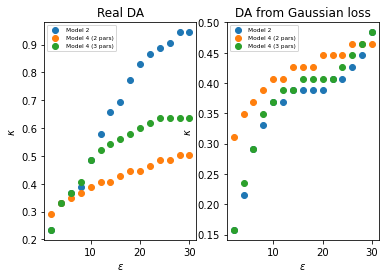

In [12]:
fig1, ax1 = plt.subplots(1,2)

p_filter = fitting_data[("type", "")] == "real" 

ax1[0].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 2", "k")],
    label="Model 2"
)
ax1[0].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (2 free pars)", "k")],
    label="Model 4 (2 pars)"
)
ax1[0].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (3 free pars)", "k")],
    label="Model 4 (3 pars)"
)

ax1[0].set_xlabel("$\\epsilon$")
ax1[0].set_ylabel("$\\kappa$")
ax1[0].set_title("Real DA")
ax1[0].legend(fontsize="xx-small")

p_filter = fitting_data[("type", "")] == "gaussian" 

ax1[1].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 2", "k")],
    label="Model 2"
)
ax1[1].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (2 free pars)", "k")],
    label="Model 4 (2 pars)"
)
ax1[1].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (3 free pars)", "k")],
    label="Model 4 (3 pars)"
)

ax1[1].set_xlabel("$\\epsilon$")
ax1[1].set_ylabel("$\\kappa$")
ax1[1].set_title("DA from Gaussian loss")
ax1[1].legend(fontsize="xx-small")

p_filter = fitting_data[("type", "")] == "uniform" 

"""
ax1[2].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 2", "k")],
    label="Model 2"
)
ax1[2].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (2 free pars)", "k")],
    label="Model 4 (2 pars)"
)
ax1[2].scatter(
    fitting_data[p_filter][("epsilon", "")],
    fitting_data[p_filter][("Model 4 (3 free pars)", "k")],
    label="Model 4 (3 pars)"
)
ax1[2].set_xlabel("$\\epsilon$")
ax1[2].set_ylabel("$\\kappa$")
ax1[2].set_title("DA from Uniform loss")
ax1[2].legend(fontsize="xx-small")
""";

In [13]:
fitting_data[["epsilon", "type", "sigma", "Model 2"]]

epsilon      type sigma   Model 2                                 \
                                   k     k err        rho   rho err   
0      2.0      real   NaN  0.234343  0.019192   1.835630  0.001863   
1      2.0   uniform   NaN  0.138384  0.019192   1.131076  0.000243   
2      2.0  gaussian   0.2  0.157576  0.019192   1.205789  0.000482   
3      4.0      real   NaN  0.330303  0.019192   2.950729  0.002771   
4      4.0   uniform   NaN  0.176768  0.019192   1.359592  0.000469   
5      4.0  gaussian   0.2  0.215152  0.019192   1.596389  0.001198   
6      6.0      real   NaN  0.368687  0.019192   3.509941  0.002510   
7      6.0   uniform   NaN  0.215152  0.019192   1.631702  0.000885   
8      6.0  gaussian   0.2  0.291919  0.019192   2.325704  0.002355   
9      8.0      real   NaN  0.387879  0.019192   3.800330  0.001897   
10     8.0   uniform   NaN  0.253535  0.019192   1.958189  0.001169   
11     8.0  gaussian   0.2  0.330303  0.019192   2.783196  0.002517   
12    10.0      real   NaN  0.483838  0.019192   6.072436  0.004085   
13    10.0   uniform   NaN  0.272727  0.019192   2.133858  0.001081   
14    10.0  gaussian   0.2  0.368687  0.019192   3.334442  0.002629   
15    12.0      real   NaN  0.579798  0.019192   9.658579  0.009915   
16    12.0   uniform   NaN  0.291919  0.019192   2.326492  0.001182   
17    12.0  gaussian   0.2  0.368687  0.019192   3.296056  0.001971   
18    14.0      real   NaN  0.656566  0.019192  13.928873  0.016458   
19    14.0   uniform   NaN  0.311111  0.019192   2.537171  0.001251   
20    14.0  gaussian   0.2  0.387879  0.019192   3.596388  0.001804   
21    16.0      real   NaN  0.694949  0.019192  16.553934  0.019473   
22    16.0   uniform   NaN  0.311111  0.019192   2.516682  0.001069   
23    16.0  gaussian   0.2  0.387879  0.019192   3.562639  0.001439   
24    18.0      real   NaN  0.771717  0.019192  23.740494  0.036355   
25    18.0   uniform   NaN  0.330303  0.019192   2.745081  0.000939   
26    18.0  gaussian   0.2  0.387879  0.019192   3.531043  0.000982   
27    20.0      real   NaN  0.829293  0.019192  30.852175  0.058613   
28    20.0   uniform   NaN  0.330303  0.019192   2.728318  0.000777   
29    20.0  gaussian   0.2  0.387879  0.019192   3.505556  0.000851   
30    22.0      real   NaN  0.867677  0.019192  36.195525  0.095800   
31    22.0   uniform   NaN  0.349495  0.019192   2.976359  0.001073   
32    22.0  gaussian   0.2  0.407071  0.019192   3.826263  0.001002   
33    24.0      real   NaN  0.886869  0.019192  38.663000  0.100705   
34    24.0   uniform   NaN  0.349495  0.019192   2.957866  0.000865   
35    24.0  gaussian   0.2  0.407071  0.019192   3.794873  0.001169   
36    26.0      real   NaN  0.906061  0.019192  41.431612  0.116709   
37    26.0   uniform   NaN  0.368687  0.019192   3.226670  0.001421   
38    26.0  gaussian   0.2  0.426263  0.019192   4.133348  0.001783   
39    28.0      real   NaN  0.944444  0.019192  48.406836  0.147140   
40    28.0   uniform   NaN  0.387879  0.019192   3.513950  0.002353   
41    28.0  gaussian   0.2  0.445455  0.019192   4.497562  0.002671   
42    30.0      real   NaN  0.944444  0.019192  47.853141  0.125729   
43    30.0   uniform   NaN  0.407071  0.019192   3.823105  0.003075   
44    30.0  gaussian   0.2  0.483838  0.019192   5.376352  0.004248   

                                        
            N0        N0 err      Chi2  
0     3.913099  1.875597e-01  0.000110  
1   202.910978  2.000384e+00  0.000038  
2    88.876989  1.705396e+00  0.000067  
3     0.327927  1.269759e-02  0.000050  
4    94.761856  1.379030e+00  0.000056  
5    24.374490  7.713150e-01  0.000121  
6     0.185349  5.104696e-03  0.000026  
7    44.184179  9.332901e-01  0.000089  
8     3.810182  1.461936e-01  0.000112  
9     0.163118  3.005942e-03  0.000012  
10   19.822601  4.330920e-01  0.000073  
11    1.809924  5.864640e-02  0.000073  
12    0.015448  3.590381e-04  0.000015  
13   14.760720  2.631576e-01  0.000047  
14    0.8

In [14]:
fitting_data[["epsilon", "type", "sigma", "Model 4 (2 free pars)"]]

epsilon      type sigma Model 4 (2 free pars)                      \
                                               k     k err       rho   
0      2.0      real   NaN              0.291919  0.019192  2.528580   
1      2.0   uniform   NaN              0.330303  0.019192  3.121093   
2      2.0  gaussian   0.2              0.311111  0.019192  2.749120   
3      4.0      real   NaN              0.330303  0.019192  2.969620   
4      4.0   uniform   NaN              0.349495  0.019192  3.370596   
5      4.0  gaussian   0.2              0.349495  0.019192  3.230869   
6      6.0      real   NaN              0.349495  0.019192  3.203132   
7      6.0   uniform   NaN              0.368687  0.019192  3.640398   
8      6.0  gaussian   0.2              0.368687  0.019192  3.485795   
9      8.0      real   NaN              0.368687  0.019192  3.458538   
10     8.0   uniform   NaN              0.387879  0.019192  3.931041   
11     8.0  gaussian   0.2              0.387879  0.019192  3.763178   
12    10.0      real   NaN              0.387879  0.019192  3.729218   
13    10.0   uniform   NaN              0.407071  0.019192  4.245400   
14    10.0  gaussian   0.2              0.407071  0.019192  4.061896   
15    12.0      real   NaN              0.407071  0.019192  4.021888   
16    12.0   uniform   NaN              0.426263  0.019192  4.581564   
17    12.0  gaussian   0.2              0.407071  0.019192  4.044215   
18    14.0      real   NaN              0.407071  0.019192  3.999251   
19    14.0   uniform   NaN              0.426263  0.019192  4.563098   
20    14.0  gaussian   0.2              0.426263  0.019192  4.367939   
21    16.0      real   NaN              0.426263  0.019192  4.314201   
22    16.0   uniform   NaN              0.426263  0.019192  4.545620   
23    16.0  gaussian   0.2              0.426263  0.019192  4.351537   
24    18.0      real   NaN              0.445455  0.019192  4.648181   
25    18.0   uniform   NaN              0.445455  0.019192  4.905066   
26    18.0  gaussian   0.2              0.426263  0.019192  4.334964   
27    20.0      real   NaN              0.445455  0.019192  4.624434   
28    20.0   uniform   NaN              0.445455  0.019192  4.891625   
29    20.0  gaussian   0.2              0.445455  0.019192  4.680148   
30    22.0      real   NaN              0.464646  0.019192  4.977479   
31    22.0   uniform   NaN              0.464646  0.019192  5.275160   
32    22.0  gaussian   0.2              0.445455  0.019192  4.664422   
33    24.0      real   NaN              0.483838  0.019192  5.352301   
34    24.0   uniform   NaN              0.464646  0.019192  5.259068   
35    24.0  gaussian   0.2              0.445455  0.019192  4.648330   
36    26.0      real   NaN              0.483838  0.019192  5.325588   
37    26.0   uniform   NaN              0.464646  0.019192  5.243864   
38    26.0  gaussian   0.2              0.464646  0.019192  5.012674   
39    28.0      real   NaN              0.503030  0.019192  5.725366   
40    28.0   uniform   NaN              0.483838  0.019192  5.651677   
41    28.0  gaussian   0.2              0.464646  0.019192  4.993789   
42    30.0      real   NaN              0.503030  0.019192  5.698385   
43    30.0   uniform   NaN              0.483838  0.019192  5.630003   
44    30.0  gaussian   0.2              0.464646  0.019192  4.975234   

                               
     rho err lambda      Chi2  
0   0.000488    0.5  0.000167  
1   0.001761    0.5  0.001500  
2   0.001092    0.5  0.000703  
3   0.000314    0.5  0.000052  
4   0.001498    0.5  0.000885  
5   0.000861    0.5  0.000319  
6   0.000280    0.5  0.000036  
7   0.001313    0.5  0.000563  
8   0.000665    0.5  0.000159  
9   0.000208    0.5  0.000017  
10  0.001178    0.5  0.000387  
11  0.000529    0.5  0.000087  
12  0.000384    0.5  0.000048  
13  0.001077    0.5  0.000284  
14  0.000494    0.5  0.000067  
15  0.000661    0.5  0.000119  
16  0.001096    0.5  0.000266  
17  0.0003

In [15]:
fitting_data[["epsilon", "type", "sigma", "Model 4 (3 free pars)"]]

epsilon      type sigma Model 4 (3 free pars)                       \
                                               k     k err        rho   
0      2.0      real   NaN              0.234343  0.019192   1.841246   
1      2.0   uniform   NaN              0.138384  0.019192   1.133767   
2      2.0  gaussian   0.2              0.157576  0.019192   1.208683   
3      4.0      real   NaN              0.330303  0.019192   2.964484   
4      4.0   uniform   NaN              0.176768  0.019192   1.363790   
5      4.0  gaussian   0.2              0.234343  0.019192   1.769843   
6      6.0      real   NaN              0.368687  0.019192   3.529348   
7      6.0   uniform   NaN              0.215152  0.019192   1.637964   
8      6.0  gaussian   0.2              0.291919  0.019192   2.336758   
9      8.0      real   NaN              0.407071  0.019192   4.223207   
10     8.0   uniform   NaN              0.253535  0.019192   1.967140   
11     8.0  gaussian   0.2              0.349495  0.019192   3.087300   
12    10.0      real   NaN              0.483838  0.019192   6.120074   
13    10.0   uniform   NaN              0.272727  0.019192   2.144629   
14    10.0  gaussian   0.2              0.368687  0.019192   3.355687   
15    12.0      real   NaN              0.522222  0.019192   7.270618   
16    12.0   uniform   NaN              0.291919  0.019192   2.339293   
17    12.0  gaussian   0.2              0.387879  0.019192   3.656028   
18    14.0      real   NaN              0.541414  0.019192   7.856494   
19    14.0   uniform   NaN              0.311111  0.019192   2.552297   
20    14.0  gaussian   0.2              0.387879  0.019192   3.621543   
21    16.0      real   NaN              0.560606  0.019192   8.507998   
22    16.0   uniform   NaN              0.330303  0.019192   2.785776   
23    16.0  gaussian   0.2              0.407071  0.019192   3.951383   
24    18.0      real   NaN              0.579798  0.019192   9.189829   
25    18.0   uniform   NaN              0.330303  0.019192   2.763043   
26    18.0  gaussian   0.2              0.407071  0.019192   3.915569   
27    20.0      real   NaN              0.598990  0.019192   9.926628   
28    20.0   uniform   NaN              0.330303  0.019192   2.746466   
29    20.0  gaussian   0.2              0.407071  0.019192   3.886724   
30    22.0      real   NaN              0.618182  0.019192  10.682352   
31    22.0   uniform   NaN              0.349495  0.019192   2.997483   
32    22.0  gaussian   0.2              0.407071  0.019192   3.856132   
33    24.0      real   NaN              0.637374  0.019192  11.501512   
34    24.0   uniform   NaN              0.349495  0.019192   2.979144   
35    24.0  gaussian   0.2              0.426263  0.019192   4.207731   
36    26.0      real   NaN              0.637374  0.019192  11.295762   
37    26.0   uniform   NaN              0.368687  0.019192   3.251382   
38    26.0  gaussian   0.2              0.445455  0.019192   4.583939   
39    28.0      real   NaN              0.637374  0.019192  11.109468   
40    28.0   uniform   NaN              0.387879  0.019192   3.542667   
41    28.0  gaussian   0.2              0.464646  0.019192   4.988860   
42    30.0      real   NaN              0.637374  0.019192  10.953281   
43    30.0   uniform   NaN              0.407071  0.019192   3.856344   
44    30.0  gaussian   0.2              0.483838  0.019192   5.429142   

                                                     
     rho err          N0    N0 err lambda      Chi2  
0   0.001831    4.485465  0.210999    0.5  0.000110  
1   0.000235  205.086037  1.946710    0.5  0.000038  
2   0.000461   92.528553  1.698230    0.5  0.000064  
3   0.002720    0.416609  0.015790    0.5  0.000050  
4   0.000456   98.879888  1.394911    0.5  0.000056  
5   0.001463   15.092161  0.519178    0.5  0.000119  
6   0.002475    0.244450  0.006613    0.5  0.000026  
7   0.000870   47.675062  0.987873    0.5  0.000091  
8   0.002309    4.516532  0.169

# Fokker-Planck Fittings
## Fixed $\kappa$, exploring $I_\ast$

In [16]:
labels = (
    ("epsilon", ""),
    ("type", ""),
    ("sigma", ""),
    ("Fokker-Planck", "I_star"),
    ("Fokker-Planck", "time_scale"),
    ("Fit data", "explored I_star"),
    ("Fit data", "errors"),
    ("Fit data", "best error"),
)

fp_data = []
fp_fit_data = pd.DataFrame(columns=pd.MultiIndex.from_tuples(labels))

In [17]:
def fp_fitting(lost_table, I_max, I0, k, I_star, dt, iter_step, turn_sampling=turn_sampling):
    # Let's print!
    print("k={}, I_star={}, dt={}".format(k, I_star, dt))
    # fixing the data
    lost_table = np.concatenate((lost_table, [1.0]))
    turn_sampling = np.concatenate((turn_sampling, [0.0]))
    # Declaring the engine
    engine_nk = nk.cn_nekhoroshev(I_max, c, I_star, 1 / (k * 2), 0, I0, dt)
    # Allocating lists and counter
    t = []
    survival = []
    step = 0
    # Starting while loop for fitting procedure
    while(1.0 - engine_nk.get_particle_loss() >= lost_table[0]):
        t.append(step * iter_step * dt)
        survival.append(1.0 - engine_nk.get_particle_loss())
        engine_nk.iterate(iter_step)
        step += 1
        if step == 10000:
            print("This thing is going for a LONG ride!")
    t.append(step * iter_step * dt)
    survival.append(1.0 - engine_nk.get_particle_loss())
    # Post processing
    f = interp1d(t, survival, kind="cubic")
    inv_f = inversefunc(
        f,
        domain=(t[0], t[-1]),
        image=(survival[-1], survival[0])
    )
    point_t = inv_f(lost_table[0])
    points_t = np.linspace(0, point_t, len(turn_sampling))
    values_f = f(points_t)
    values_f = values_f[::-1]
    error = chi_2(lost_table, values_f)
    # Returning the thing
    return values_f, np.asarray(t)[::-1], error, step 

In [18]:
step_propotion = 0.05
for i in tqdm(range(len(fitting_data[("Model 4 (3 free pars)", "k")]))):
    if fitting_data[("type","")][i] != "uniform":
        k = fitting_data[("Model 4 (3 free pars)", "k")][i]
        rho = fitting_data[("Model 4 (3 free pars)", "rho")][i]
        N0 = fitting_data[("Model 4 (3 free pars)", "N0")][i]

        I_max = cut_point**2 / 2
        I = np.linspace(0, I_max, 1000)
        I0 = I * np.exp(-(I/sigma**2))
        I0 /= integrate.trapz(I0, I)

        c = 1.0

        I_star_start = 0.2
        I_star_up = I_star_start * (1 + step_propotion)
        I_star_down = I_star_start * (1 - step_propotion)

        I_star_sampled = []
        errors = []

        dt = 0.01
        iter_step = 10
        # first 3 analysis
        values_down, t_down, error_down, step_down = fp_fitting(lost_table[i], I_max, I0, k, I_star_down, dt, iter_step)
        if step_down > 1000:
            print("down increase!")
            dt *= 10
        values_start, t_start, error_start, step_start = fp_fitting(lost_table[i], I_max, I0, k, I_star_start, dt, iter_step)
        if step_start > 1000:
            print("start increase!")
            dt *= 10
        values_up, t_up, error_up, step_up = fp_fitting(lost_table[i], I_max, I0, k, I_star_up, dt, iter_step)
        if step_up > 1000:
            print("up increase!")
            dt *= 10

        I_star_sampled.append(I_star_start)
        errors.append(error_start)

        if error_up < error_start and error_up < error_down:
            print("Going UP!")
            I_star_sampled.append(I_star_up)
            errors.append(error_up)
            I_star_now = I_star_up
            values_now = values_up
            t_now = t_up
            while errors[-1] < errors[-2]:
                I_star_new = I_star_now * (1 + step_propotion)
                values, t, error, step = fp_fitting(lost_table[i], I_max, I0, k, I_star_new, dt, iter_step)
                if error > errors[-1]:
                    I_star_sampled.append(I_star_new)
                    errors.append(error)
                    break
                values_now = values
                t_now = t
                I_star_now = I_star_new
                I_star_sampled.append(I_star_now)
                errors.append(error)
                if step > 1000:
                    print("increase!")
                    dt *= 10
            fp_data.append(values_now)
            fp_fit_data.loc[len(fp_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                I_star_now,
                t_now,
                I_star_sampled,
                errors,
                np.min(errors)
            ]
        elif error_down < error_start and error_down < error_up:
            print("Going DOWN!")
            I_star_sampled.append(I_star_down)
            errors.append(error_down)
            I_star_now = I_star_up
            values_now = values_up
            t_now = t_up
            while errors[-1] < errors[-2]:
                I_star_new = I_star_now * (1 - step_propotion)
                values, t, error, step = fp_fitting(lost_table[i], I_max, I0, k, I_star_new, dt, iter_step)
                if error > errors[-1]:
                    I_star_sampled.append(I_star_new)
                    errors.append(error)
                    break
                values_now = values
                t_now = t
                I_star_now = I_star_new
                I_star_sampled.append(I_star_now)
                errors.append(error)
                if step > 1000:
                    print("increase!")
                    dt *= 2
            fp_data.append(values_now)
            fp_fit_data.loc[len(fp_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                I_star_now,
                t_now,
                I_star_sampled,
                errors,
                np.min(errors)
            ]
        else:
            print("STAYNG HERE!")
            fp_data.append(values_start)
            fp_fit_data.loc[len(fp_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                I_star_start,
                t_start,
                I_star_sampled,
                errors,
                np.min(errors)
            ]

            

k=0.23434343434343433, I_star=0.19, dt=0.01
k=0.23434343434343433, I_star=0.2, dt=0.01
k=0.23434343434343433, I_star=0.21000000000000002, dt=0.01
Going UP!
k=0.23434343434343433, I_star=0.22050000000000003, dt=0.01
k=0.23434343434343433, I_star=0.23152500000000004, dt=0.01
k=0.23434343434343433, I_star=0.24310125000000005, dt=0.01
k=0.23434343434343433, I_star=0.2552563125000001, dt=0.01
k=0.23434343434343433, I_star=0.2680191281250001, dt=0.01
k=0.23434343434343433, I_star=0.2814200845312501, dt=0.01
k=0.23434343434343433, I_star=0.29549108875781266, dt=0.01
increase!
k=0.23434343434343433, I_star=0.3102656431957033, dt=0.1
k=0.23434343434343433, I_star=0.3257789253554885, dt=0.1
k=0.1575757575757576, I_star=0.19, dt=0.01
k=0.1575757575757576, I_star=0.2, dt=0.01
k=0.1575757575757576, I_star=0.21000000000000002, dt=0.01
Going UP!
k=0.1575757575757576, I_star=0.22050000000000003, dt=0.01
k=0.3303030303030303, I_star=0.19, dt=0.01
k=0.3303030303030303, I_star=0.2, dt=0.01
k=0.3303030303

In [19]:
fp_fit_data

epsilon      type sigma Fokker-Planck  \
                                  I_star   
0      2.0      real   NaN      0.310266   
1      2.0  gaussian   0.2      0.210000   
2      4.0      real   NaN      0.481324   
3      4.0  gaussian   0.2      0.281420   
4      6.0      real   NaN      0.557193   
5      6.0  gaussian   0.2      0.377130   
6      8.0      real   NaN      0.677271   
7      8.0  gaussian   0.2      0.481324   
8     10.0      real   NaN      1.050670   
9     10.0  gaussian   0.2      0.530660   
10    12.0      real   NaN      1.277095   
11    12.0  gaussian   0.2      0.585052   
12    14.0      real   NaN      1.478398   
13    14.0  gaussian   0.2      0.557193   
14    16.0      real   NaN      1.629933   
15    16.0  gaussian   0.2      0.614305   
16    18.0      real   NaN      1.797002   
17    18.0  gaussian   0.2      0.614305   
18    20.0      real   NaN      1.981194   
19    20.0  gaussian   0.2      0.614305   
20    22.0      real   NaN      2.184267   
21    22.0  gaussian   0.2      0.585052   
22    24.0      real   NaN      2.408154   
23    24.0  gaussian   0.2      0.645020   
24    26.0      real   NaN      2.408154   
25    26.0  gaussian   0.2      0.711135   
26    28.0      real   NaN      2.293480   
27    28.0  gaussian   0.2      0.784026   
28    30.0      real   NaN      2.184267   
29    30.0  gaussian   0.2      0.864388   

                                                       \
                                           time_scale   
0   [464.0, 463.0, 462.0, 461.0, 460.0, 459.0, 458...   
1   [14.200000000000001, 14.1, 14.0, 13.9, 13.8, 1...   
2   [3940.0, 3930.0, 3920.0, 3910.0, 3900.0, 3890....   
3   [69.10000000000001, 69.0, 68.9, 68.8, 68.7, 68...   
4   [4740.0, 4730.0, 4720.0, 4710.0, 4700.0, 4690....   
5   [726.0, 725.0, 724.0, 723.0, 722.0, 721.0, 720...   
6   [12980.0, 12970.0, 12960.0, 12950.0, 12940.0, ...   
7   [1509.0, 1508.0, 1507.0, 1506.0, 1505.0, 1504....   
8   [128800.0, 128700.0, 128600.0, 128500.0, 12840...   
9   [2910.0, 2900.0, 2890.0, 2880.0, 2870.0, 2860....   
10  [235900.0, 235800.0, 235700.0, 235600.0, 23550...   
11  [5200.0, 5190.0, 5180.0, 5170.0, 5160.0, 5150....   
12  [805000.0, 804000.0, 803000.0, 802000.0, 80100...   
13  [2390.0, 2380.0, 2370.0, 2360.0, 2350.0, 2340....   
14  [1083000.0, 1082000.0, 1081000.0, 1080000.0, 1...   
15  [4050.0, 4040.0, 4030.0, 4020.0, 4010.0, 4000....   
16  [1442000.0, 1441000.0, 1440000.0, 1439000.0, 1...   
17  [4690.0, 4680.0, 4670.0, 4660.0, 4650.0, 4640....   
18  [1859000.0, 1858000.0, 1857000.0, 1856000.0, 1...   
19  [5350.0, 5340.0, 5330.0, 5320.0, 5310.0, 5300....   
20  [2390000.0, 2380000.0, 2370000.0, 2360000.0, 2...   
21  [2520.0, 2510.0, 2500.0, 2490.0, 2480.0, 2470....   
22  [3030000.0, 3020000.0, 3010000.0, 3000000.0, 2...   
23  [4150.0, 4140.0, 4130.0, 4120.0, 4110.0, 4100....   
24  [3480000.0, 3470000.0, 3460000.0, 3450000.0, 3...   
25  [6740.0, 6730.0, 6720.0, 6710.0, 6700.0, 6690....   
26  [1788000.0, 1787000.0, 1786000.0, 1785000.0, 1...   
27  [10760.0, 10750.0, 10740.0, 10730.0, 10720.0, ...   
28  [934000.0, 933000.0, 932000.0, 931000.0, 93000...   
29  [16680.0, 16670.0, 16660.0, 16650.0, 16640.0, ...   

                                             Fit data  \
                                      explored I_star   
0   [0.2, 0.21000000000000002, 0.22050000000000003...   
1     [0.2, 0.21000000000000002, 0.22050000000000003]   
2   [0.2, 0.21000000000000002, 0.22050000000000003...   
3   [0.2, 0.21000000000000002, 0.22050000000000003...   
4   [0.2, 0.21000000000000002, 0.22050000000000003...   
5   [0.2, 0.21000000000000002, 0.22050000000000003...   
6   [0.2, 0.21000000000000002, 0.22050000000000003...   
7   [0.2, 0.21000000000000002, 0.22050000000000003...   
8   [0.2, 0.21000000000000002, 0.22050000000000003...   
9   [0.2, 0.21000000000000002, 0.22050000000000003...   
10  [0.2, 0.21000000000000002, 0.22050000000000003...   
11  [0.2, 0.2100000000000000

Text(0.5, 1.0, 'Best value for $I_\\ast$')

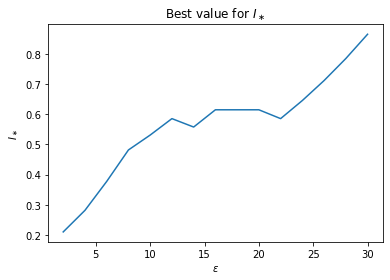

In [20]:
plt.figure()

plt.plot(
    fp_fit_data[fp_fit_data[("type")] == "gaussian"][("epsilon")],
    fp_fit_data[fp_fit_data[("type")] == "gaussian"][("Fokker-Planck", "I_star")]
)
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Best value for $I_\\ast$")

## Double FP fit for both $\kappa$ and $I_\ast$

In [21]:
labels = (
    ("epsilon", ""),
    ("type", ""),
    ("sigma", ""),
    ("Fokker-Planck", "k"),
    ("Fokker-Planck", "I_star"),
    ("Fokker-Planck", "time_scale"),
    ("Fit data", "explored k"),
    ("Fit data", "selected I_star"),
    ("Fit data", "errors"),
    ("Fit data", "best error"),
)

fp_double_data = []
fp_double_fit_data = pd.DataFrame(columns=pd.MultiIndex.from_tuples(labels))

In [22]:
def scan_I_star(lost_table, I_max, I0, k, I_star_start, dt, iter_step, step_proportion = 0.05):
    I_star_sampled = []
    errors = []
    I_star_up = I_star_start * (1 + step_proportion)
    I_star_down = I_star_start * (1 - step_proportion)
    # first 3 analysis
    values_down, t_down, error_down, step_down = fp_fitting(lost_table, I_max, I0, k, I_star_down, dt, iter_step)
    if step_down > 1000:
        print("down increase!")
        dt *= 10
    values_start, t_start, error_start, step_start = fp_fitting(lost_table, I_max, I0, k, I_star_start, dt, iter_step)
    if step_start > 1000:
        print("start increase!")
        dt *= 10
    values_up, t_up, error_up, step_up = fp_fitting(lost_table, I_max, I0, k, I_star_up, dt, iter_step)
    if step_up > 1000:
        print("up increase!")
        dt *= 10

    I_star_sampled.append(I_star_start)
    errors.append(error_start)

    if error_up < error_start and error_up < error_down:
        print("Going UP!")
        I_star_sampled.append(I_star_up)
        errors.append(error_up)
        I_star_now = I_star_up
        values_now = values_up
        t_now = t_up
        while errors[-1] < errors[-2]:
            I_star_new = I_star_now * (1 + step_propotion)
            values, t, error, step = fp_fitting(lost_table, I_max, I0, k, I_star_new, dt, iter_step)
            if error > errors[-1]:
                I_star_sampled.append(I_star_new)
                errors.append(error)
                break
            values_now = values
            t_now = t
            I_star_now = I_star_new
            I_star_sampled.append(I_star_now)
            errors.append(error)
            if step > 1000:
                print("increase!")
                dt *= 10
        return values_now, I_star_now, t_now, np.min(errors)
    
    elif error_down < error_start and error_down < error_up:
        print("Going DOWN!")
        I_star_sampled.append(I_star_down)
        errors.append(error_down)
        I_star_now = I_star_up
        values_now = values_up
        t_now = t_up
        while errors[-1] < errors[-2]:
            I_star_new = I_star_now * (1 - step_propotion)
            values, t, error, step = fp_fitting(lost_table, I_max, I0, k, I_star_new, dt, iter_step)
            if error > errors[-1]:
                I_star_sampled.append(I_star_new)
                errors.append(error)
                break
            values_now = values
            t_now = t
            I_star_now = I_star_new
            I_star_sampled.append(I_star_now)
            errors.append(error)
            if step > 1000:
                print("increase!")
                dt *= 2
        return values_now, I_star_now, t_now, np.min(errors)

    else:
        print("STAYNG HERE!")
        return values_start, I_star_start, t_start, np.min(errors)           

In [23]:
k_proportion_step = 0.01
for i in tqdm(range(len(fitting_data[("Model 4 (3 free pars)", "k")]))):
    if fitting_data[("type","")][i] != "uniform":
        k_start = fitting_data[("Model 4 (3 free pars)", "k")][i]
        k_up = k_start * (1 + k_proportion_step)
        k_down = k_start * (1 - k_proportion_step)

        rho = fitting_data[("Model 4 (3 free pars)", "rho")][i]
        N0 = fitting_data[("Model 4 (3 free pars)", "N0")][i]

        I_max = cut_point**2 / 2
        I = np.linspace(0, I_max, 1000)
        I0 = I * np.exp(-(I/sigma**2))
        I0 /= integrate.trapz(I0, I)

        c = 1.0
        I_star_default = 0.2

        iter_step = 10

        k_sampled = []
        I_star_selected = []
        errors = []

        dt = 0.001

        #first 3 steps
        values_down, I_star_down, t_down, error_down = scan_I_star(lost_table[i], I_max, I0, k_down, I_star_default, dt, iter_step)
        values_start, I_star_start, t_start, error_start = scan_I_star(lost_table[i], I_max, I0, k_start, I_star_default, dt, iter_step)
        values_up, I_star_up, t_up, error_up = scan_I_star(lost_table[i], I_max, I0, k_up, I_star_default, dt, iter_step)

        k_sampled.append(k_start)
        I_star_selected.append(I_star_start)
        errors.append(error_start)

        if error_up < error_start and error_up < error_down:
            print("Going UP with k!!!")
            k_sampled.append(k_up)
            I_star_selected.append(I_star_up)
            errors.append(error_up)
            k_now = k_up
            I_star_now = I_star_up
            values_now = values_up
            t_now = t_up
            while errors[-1] < errors[-2]:
                k_new = k_now * (1 + k_proportion_step)
                values, I_star, t, error = scan_I_star(lost_table[i], I_max, I0, k_new, I_star_default, dt, iter_step)
                if error > errors[-1]:
                    k_sampled.append(k_new)
                    I_star_selected.append(I_star)
                    errors.append(error)
                    break
                values_now = values
                t_now = t
                k_now = k_new
                I_star_now = I_star
                k_sampled.append(k_now)
                I_star_selected.append(I_star_now)
                errors.append(error)
                if step > 1000:
                    print("increase!")
                    dt *= 10
            fp_double_data.append(values_now)
            fp_double_fit_data.loc[len(fp_double_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                k_now,
                I_star_now,
                t_now,
                k_sampled,
                I_star_selected,
                errors,
                np.min(errors)
            ]
        elif error_down < error_start and error_down < error_up:
            print("Going DOWN with k!!!")
            k_sampled.append(k_down)
            I_star_selected.append(I_star_down)
            errors.append(error_down)
            k_now = k_down
            I_star_now = I_star_down
            values_now = values_down
            t_now = t_down
            while errors[-1] < errors[-2]:
                k_new = k_now * (1 - k_proportion_step)
                values, I_star, t, error = scan_I_star(lost_table[i], I_max, I0, k_new, I_star_default, dt, iter_step)
                if error > errors[-1]:
                    k_sampled.append(k_new)
                    I_star_selected.append(I_star)
                    errors.append(error)
                    break
                values_now = values
                t_now = t
                k_now = k_new
                I_star_now = I_star
                k_sampled.append(k_now)
                I_star_selected.append(I_star_now)
                errors.append(error)
                if step > 1000:
                    print("increase!")
                    dt *= 10
            fp_double_data.append(values_now)
            fp_double_fit_data.loc[len(fp_double_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                k_now,
                I_star_now,
                t_now,
                k_sampled,
                I_star_selected,
                errors,
                np.min(errors)
            ]
        else:
            print("STAYNG HERE!")
            fp_double_data.append(values_start)
            fp_double_fit_data.loc[len(fp_double_fit_data)] = [
                fitting_data[("epsilon", "")][i],
                fitting_data[("type", "")][i],
                fitting_data[("sigma", "")][i],
                k_start,
                I_star_start,
                t_start,
                k_sampled,
                I_star_selected,
                errors,
                np.min(errors)
            ]

k=0.23199999999999998, I_star=0.19, dt=0.001
k=0.23199999999999998, I_star=0.2, dt=0.001
k=0.23199999999999998, I_star=0.21000000000000002, dt=0.001
Going UP!
k=0.23199999999999998, I_star=0.22050000000000003, dt=0.001
k=0.23199999999999998, I_star=0.23152500000000004, dt=0.001
k=0.23199999999999998, I_star=0.24310125000000005, dt=0.001
k=0.23199999999999998, I_star=0.2552563125000001, dt=0.001
k=0.23199999999999998, I_star=0.2680191281250001, dt=0.001
increase!
k=0.23199999999999998, I_star=0.2814200845312501, dt=0.01
k=0.23199999999999998, I_star=0.29549108875781266, dt=0.01
increase!
k=0.23199999999999998, I_star=0.3102656431957033, dt=0.1
k=0.23434343434343433, I_star=0.19, dt=0.001
k=0.23434343434343433, I_star=0.2, dt=0.001
k=0.23434343434343433, I_star=0.21000000000000002, dt=0.001
Going UP!
k=0.23434343434343433, I_star=0.22050000000000003, dt=0.001
k=0.23434343434343433, I_star=0.23152500000000004, dt=0.001
k=0.23434343434343433, I_star=0.24310125000000005, dt=0.001
k=0.234343

In [24]:
fp_double_fit_data

epsilon      type sigma Fokker-Planck            \
                                       k    I_star   
0      2.0      real   NaN      0.239054  0.310266   
1      2.0  gaussian   0.2      0.154440  0.210000   
2      4.0      real   NaN      0.330303  0.481324   
3      4.0  gaussian   0.2      0.229680  0.281420   
4      6.0      real   NaN      0.368687  0.557193   
5      6.0  gaussian   0.2      0.286110  0.359171   
6      8.0      real   NaN      0.407071  0.677271   
7      8.0  gaussian   0.2      0.346000  0.481324   
8     10.0      real   NaN      0.483838  1.050670   
9     10.0  gaussian   0.2      0.368687  0.530660   
10    12.0      real   NaN      0.511830  1.216281   
11    12.0  gaussian   0.2      0.387879  0.585052   
12    14.0      real   NaN      0.530640  1.340950   
13    14.0  gaussian   0.2      0.384000  0.557193   
14    16.0      real   NaN      0.549450  1.478398   
15    16.0  gaussian   0.2      0.403000  0.614305   
16    18.0      real   NaN      0.574000  1.711430   
17    18.0  gaussian   0.2      0.407071  0.614305   
18    20.0      real   NaN      0.593000  1.886852   
19    20.0  gaussian   0.2      0.398970  0.585052   
20    22.0      real   NaN      0.618182  2.184267   
21    22.0  gaussian   0.2      0.403000  0.585052   
22    24.0      real   NaN      0.637374  2.408154   
23    24.0  gaussian   0.2      0.422000  0.645020   
24    26.0      real   NaN      0.612259  1.981194   
25    26.0  gaussian   0.2      0.445455  0.711135   
26    28.0      real   NaN      0.624690  2.080254   
27    28.0  gaussian   0.2      0.464646  0.784026   
28    30.0      real   NaN      0.643747  2.293480   
29    30.0  gaussian   0.2      0.479000  0.823227   

                                                       \
                                           time_scale   
0   [282.3, 282.2, 282.1, 282.0, 281.9000000000000...   
1   [19.93, 19.92, 19.91, 19.900000000000002, 19.8...   
2   [3940.0, 3930.0, 3920.0, 3910.0, 3900.0, 3890....   
3   [103.2, 103.10000000000001, 103.0, 102.9, 102....   
4   [4740.0, 4730.0, 4720.0, 4710.0, 4700.0, 4690....   
5   [395.0, 394.0, 393.0, 392.0, 391.0, 390.0, 389...   
6   [12980.0, 12970.0, 12960.0, 12950.0, 12940.0, ...   
7   [1996.0, 1995.0, 1994.0, 1993.0, 1992.0, 1991....   
8   [128800.0, 128700.0, 128600.0, 128500.0, 12840...   
9   [2910.0, 2900.0, 2890.0, 2880.0, 2870.0, 2860....   
10  [227600.0, 227500.0, 227400.0, 227300.0, 22720...   
11  [5200.0, 5190.0, 5180.0, 5170.0, 5160.0, 5150....   
12  [331000.0, 330000.0, 329000.0, 328000.0, 32700...   
13  [3200.0, 3190.0, 3180.0, 3170.0, 3160.0, 3150....   
14  [471000.0, 470000.0, 469000.0, 468000.0, 46700...   
15  [5500.0, 5490.0, 5480.0, 5470.0, 5460.0, 5450....   
16  [979000.0, 978000.0, 977000.0, 976000.0, 97500...   
17  [4690.0, 4680.0, 4670.0, 4660.0, 4650.0, 4640....   
18  [1295000.0, 1294000.0, 1293000.0, 1292000.0, 1...   
19  [3970.0, 3960.0, 3950.0, 3940.0, 3930.0, 3920....   
20  [2390000.0, 2380000.0, 2370000.0, 2360000.0, 2...   
21  [3370.0, 3360.0, 3350.0, 3340.0, 3330.0, 3320....   
22  [3030000.0, 3020000.0, 3010000.0, 3000000.0, 2...   
23  [5630.0, 5620.0, 5610.0, 5600.0, 5590.0, 5580....   
24  [958000.0, 957000.0, 956000.0, 955000.0, 95400...   
25  [6740.0, 6730.0, 6720.0, 6710.0, 6700.0, 6690....   
26  [957000.0, 956000.0, 955000.0, 954000.0, 95300...   
27  [10760.0, 10750.0, 10740.0, 10730.0, 10720.0, ...   
28  [1266000.0, 1265000.0, 1264000.0, 1263000.0, 1...   
29  [10380.0, 10370.0, 10360.0, 10350.0, 10340.0, ...   

                                             Fit data  \
                                           explored k   
0   [0.23434343434343433, 0.23668686868686867, 0.2...   
1   [0.1575757575757576, 0.15600000000000003, 0.15...   
2                                [0.3303030303030303]   
3   [0.23434343434343433, 0.23199999999999998, 0.2...   
4                                [0.3686868686868686]   
5   [0.2919191919191919, 0.289, 0.28611, 0.2832488

Text(0.5, 1.0, 'Comparison between Model 4 best fit and Fokker-Planck result')

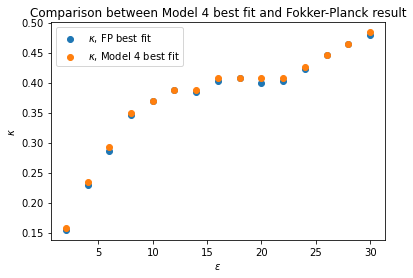

In [25]:
plt.figure()
plt.scatter(
    fp_double_fit_data[fp_double_fit_data["type"] == "gaussian"]["epsilon"],
    fp_double_fit_data[fp_double_fit_data["type"] == "gaussian"][("Fokker-Planck", "k")],
    label="$\\kappa$, FP best fit"
)
plt.scatter(
    fitting_data[fitting_data["type"] == "gaussian"]["epsilon"],
    fitting_data[fitting_data["type"] == "gaussian"][("Model 4 (3 free pars)", "k")],
    label="$\\kappa$, Model 4 best fit"
)

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\kappa$")
plt.title("Comparison between Model 4 best fit and Fokker-Planck result")

Text(0.5, 1.0, 'Comparison between Model 4 best fit and Fokker-Planck result')

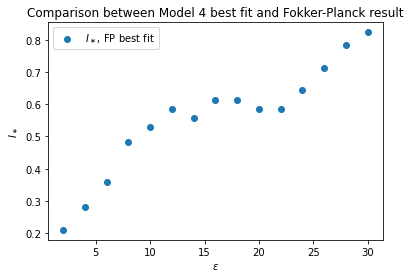

In [27]:
plt.figure()
plt.scatter(
    fp_double_fit_data[fp_double_fit_data["type"] == "gaussian"]["epsilon"],
    fp_double_fit_data[fp_double_fit_data["type"] == "gaussian"][("Fokker-Planck", "I_star")],
    label="$I_\\ast$, FP best fit"
)

plt.legend()
plt.xlabel("$\\varepsilon$")
plt.ylabel("$I_\\ast$")
plt.title("Comparison between Model 4 best fit and Fokker-Planck result")